In [1]:
import os
import io
import trimesh
import b3d
import genjax
import jax
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
from b3d import Pose
from b3d import Mesh, Pose
from b3d.pose import Pose, camera_from_position_and_target
import matplotlib.pyplot as plt
import h5py
import b3d.utils as utils
from scipy.spatial.transform import Rotation as scipyR

In [2]:
def scale_mesh(vertices, scale_factor):
    vertices[:, 0] *= scale_factor[0]
    vertices[:, 1] *= scale_factor[1]
    vertices[:, 2] *= scale_factor[2]
    return vertices

def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.array([x, y, z, w])



In [3]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

resnet_inference_path = os.path.join(
    b3d.get_root_path(),
    "resnet_results/",)

stim_name = 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0004'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

mesh_file_path = os.path.join(physion_assets_path,
    f"all_flex_meshes/core",
)

json_file_path = os.path.join(resnet_inference_path,
    f"{stim_name}.json",
)

im_width = 350
im_height = 350

In [4]:
vfov = 54.43222 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = jnp.array(f['frames'][key]['images']['_depth_cam0'])
        depth_arr.append(depth)
        image = jnp.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
    depth_arr = jnp.asarray(depth_arr)
    image_arr = jnp.asarray(image_arr)
    im_seg = np.array(Image.open(io.BytesIO(f['frames']['0000']['images']['_id_cam0'][:])).resize((im_width, im_height), Image.BICUBIC))
    FINAL_T, height, width = image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]

    # extract camera info
    camera_azimuth = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))
    projection_matrix = np.array(f['frames']['0010']['camera_matrices']['projection_matrix_cam0']).reshape((4, 4))
  
    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov

    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    assert len(object_ids) == len(model_names)
    distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else None
    occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else None
    initial_position = np.array(f['static']['initial_position'])
    initial_rotation = np.array(f['static']['initial_rotation'])
    scales = np.array(f['static']['scale'])
    if "base_id" in np.array(f['static']) and "attachment_id" in np.array(f['static']):
        base_id = np.array(f['static']['base_id'])
        base_type = np.array(f['static']['base_type'])
        attachment_id = np.array(f['static']['attachment_id'])
        attachent_type = np.array(f['static']['attachent_type'])
        attachment_fixed = np.array(f['static']['attachment_fixed'])
        use_attachment = np.array(f['static']['use_attachment'])
        use_base = np.array(f['static']['use_base'])
        use_cap = np.array(f['static']['use_cap'])
        assert attachment_id.size==1
        assert base_id.size==1
        attachment_id = attachment_id.item()
        base_id = base_id.item()
        print(base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap)

4 b'cylinder' 5 b'cone' True True True False


In [5]:
scales

array([[7.        , 0.02      , 7.        ],
       [0.4       , 0.4       , 0.4       ],
       [0.52601004, 0.1       , 0.52601004],
       [0.3684644 , 0.41977426, 0.35671315],
       [0.3502259 , 0.45      , 0.39841333],
       [0.3712331 , 0.35      , 0.3739284 ]], dtype=float32)

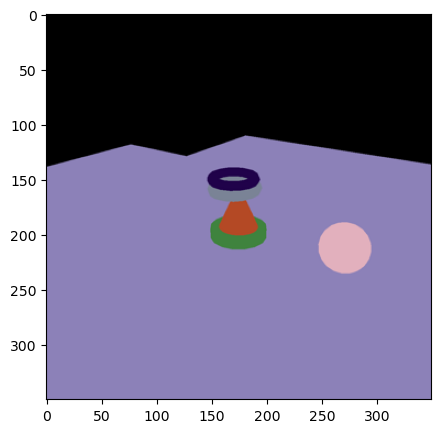

In [6]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax.imshow(im_seg)

In [7]:
distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
excluded_model_ids = distractor_ids+occluder_ids
included_model_ids = [idx for idx in range(len(object_ids)) if idx not in excluded_model_ids]
included_model_names = [model_names[idx] for idx in included_model_ids]


In [8]:
object_initial_positions = [pos for idx, pos in enumerate(initial_position) if idx in included_model_ids]
object_initial_rotations = [rot for idx, rot in enumerate(initial_rotation) if idx in included_model_ids]
object_scales = [scale for idx, scale in enumerate(scales) if idx in included_model_ids]
object_meshes = []
for idx, model_name in enumerate(included_model_names):
    trim = trimesh.load(os.path.join(mesh_file_path, f"{model_name.decode('UTF-8')}.obj"))
    object_meshes.append((scale_mesh(trim.vertices, object_scales[idx]), trim.faces))


In [9]:
included_model_names

[b'cube', b'sphere', b'cylinder', b'cone', b'torus', b'torus']

In [10]:
b3d.rr_init("demo_physion")

In [32]:
all_object_poses = []
all_meshes = []
for idx in range(len(included_model_ids)):
    if idx in [2,3]:
        print(len(object_meshes[idx][0]), len(object_meshes[idx][1]))
        object_pose = Pose(jnp.asarray(object_initial_positions[idx]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[idx])))
        # print(object_pose)
        b3d.rr_log_pose(f"{idx}", object_pose)
        all_object_poses.append(object_pose)

        mesh = trimesh.Trimesh(vertices=object_meshes[idx][0], faces=object_meshes[idx][1])
        mesh = b3d.Mesh.from_trimesh(mesh)
        all_meshes.append(mesh)
        mesh.transform(object_pose).rr_visualize(f"mesh_{idx}")

96 188
191 378


In [ ]:
merged_mesh = b3d.Mesh.transform_and_merge_meshes(all_meshes, all_object_poses)
merged_mesh.save('/home/haoliangwang/b3d/assets/physion/all_flex_meshes/core/cone_cyn_96_191.obj')

In [15]:
mesh.vertices[96:]

TrackedArray([[ 0.        ,  0.1       , -0.17835657],
              [ 0.        ,  0.1       ,  0.17835657],
              [ 0.        ,  0.51977426,  0.        ],
              [ 0.        ,  0.23992461,  0.11890426],
              [ 0.        ,  0.23992461, -0.11890426],
              [ 0.        ,  0.37984964,  0.05945231],
              [ 0.        ,  0.37984964, -0.05945231],
              [-0.03460286,  0.1       ,  0.17354023],
              [-0.03460286,  0.1       , -0.17354023],
              [-0.03460286,  0.23992461, -0.11408792],
              [-0.03460286,  0.23992461,  0.11408792],
              [-0.03696103,  0.1       , -0.05316845],
              [ 0.06780408,  0.1       ,  0.16410232],
              [ 0.06780408,  0.1       , -0.16410232],
              [ 0.03320122,  0.1       ,  0.16891865],
              [ 0.03320122,  0.37984964,  0.0500144 ],
              [ 0.03320122,  0.37984964, -0.0500144 ],
              [ 0.06531105,  0.1       ,  0.01046168],
          

In [19]:
a = 1
len(a)

TypeError: object of type 'int' has no len()

In [18]:
mesh = trimesh.load('/home/haoliangwang/b3d/assets/physion/all_flex_meshes/core/cone_cyn_96_191.obj')

mesh = trimesh.Trimesh(vertices=mesh.vertices[96:], faces=mesh.faces[188:])
mesh = b3d.Mesh.from_trimesh(mesh)
mesh.rr_visualize(f"mesh_{idx}")

IndexError: index 195 is out of bounds for axis 0 with size 191

In [ ]:
scale_mesh

mesh = trimesh.Trimesh(vertices=mesh.vertices[96:], faces=mesh.faces[188:])
mesh = b3d.Mesh.from_trimesh(mesh)
mesh.rr_visualize(f"mesh_{idx}")